Model Accuracy R2 Score: %-7.35

Netflix scenario simulation
Turkey high inflation comedy predicted views 3,876,956
Italy low inflation comedy predicted views 2,496,088
Turkey high inflation drama predicted views 4,654,709


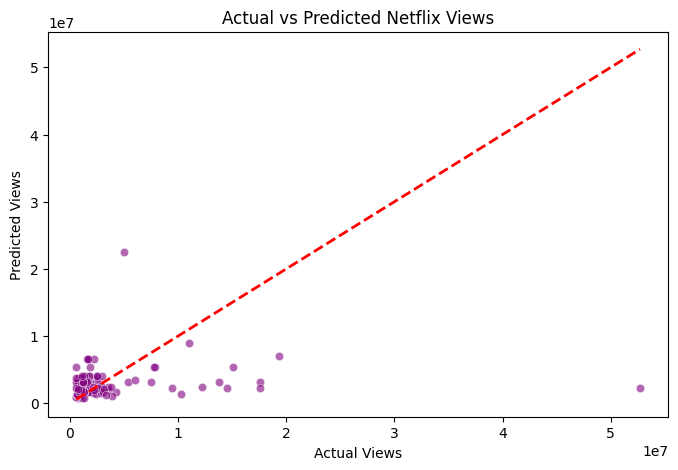

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1 Data preparation
# Load datasets
df_tr = pd.read_csv('tr.list.csv', sep=';')
df_it = pd.read_csv('Italy.list.csv', sep=';')
df_eco = pd.read_csv('economics_data2.csv', sep=';', decimal=',')

# Clean data
df_tr['Year'] = df_tr['Year'].astype(str)
df_it['Year'] = df_it['Year'].astype(str).str.replace('..', '.', regex=False)
df_eco['Year'] = df_eco['Year'].astype(str)

if df_eco['Misery_Index'].dtype == 'O':
    df_eco['Misery_Index'] = df_eco['Misery_Index'].str.replace(',', '.').astype(float)
if df_eco['Tot_mean_infrate'].dtype == 'O':
    df_eco['Tot_mean_infrate'] = df_eco['Tot_mean_infrate'].str.replace(',', '.').astype(float)
if df_eco['Tot_mean_unemprate'].dtype == 'O':
    df_eco['Tot_mean_unemprate'] = df_eco['Tot_mean_unemprate'].str.replace(',', '.').astype(float)

# Merge datasets
df_tr['Country'] = 'Turkey'
df_it['Country'] = 'Italy'
df_movies = pd.concat([df_tr, df_it])
data = pd.merge(df_movies, df_eco, on=['Country', 'Year'])

# 2 Feature selection
# Inputs country genre inflation unemployment
# Target views

features = data[['Country', 'Genre', 'Tot_mean_infrate', 'Tot_mean_unemprate']]
target = data['Views']

# Convert categorical values
X = pd.get_dummies(features, drop_first=False)
y = target

# 3 Model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model performance
score = model.score(X_test, y_test)
print(f"Model Accuracy R2 Score: %{score*100:.2f}")

# 4 Prediction function
def predict_netflix_views(country, genre, inflation, unemployment):
    """
    Predict view count for a given scenario
    """
    input_data = pd.DataFrame(0, index=[0], columns=X.columns)

    input_data['Tot_mean_infrate'] = inflation
    input_data['Tot_mean_unemprate'] = unemployment

    if f'Country_{country}' in input_data.columns:
        input_data[f'Country_{country}'] = 1

    genre = genre.strip()
    if f'Genre_{genre}' in input_data.columns:
        input_data[f'Genre_{genre}'] = 1

    prediction = model.predict(input_data)[0]
    return prediction

# 5 Example scenarios
print("\nNetflix scenario simulation")

views_tr = predict_netflix_views(
    country='Turkey', genre='Comedy', inflation=70, unemployment=10
)
print(f"Turkey high inflation comedy predicted views {views_tr:,.0f}")

views_it = predict_netflix_views(
    country='Italy', genre='Comedy', inflation=5, unemployment=8
)
print(f"Italy low inflation comedy predicted views {views_it:,.0f}")

views_tr_drama = predict_netflix_views(
    country='Turkey', genre='Drama', inflation=70, unemployment=10
)
print(f"Turkey high inflation drama predicted views {views_tr_drama:,.0f}")

# 6 Visualization actual vs predicted
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Actual vs Predicted Netflix Views')
plt.show()
